# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Loading Data 

In [35]:
# fetch dataset 
waveform_database_generator_version_1 = fetch_ucirepo(id=107) 
statlog_german_credit_data = fetch_ucirepo(id=144)

In [36]:
# extracting features and tragets for both datasets
german_data_X = statlog_german_credit_data.data.features
german_data_Y = statlog_german_credit_data.data.targets

waveform_data_X = waveform_database_generator_version_1.data.features
waveform_data_Y = waveform_database_generator_version_1.data.targets

In [37]:
# waveform dataset
display(waveform_data_X.head())
display(waveform_data_Y.head())
non_numeric_w = waveform_data_X.select_dtypes(include='object').columns
display(non_numeric_w)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,Attribute21
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,4.20,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.61,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,1.45,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,4.05,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.79,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68


,class
0,2
1,1
2,0
3,1
4,1


Index([], dtype='object')

# Preprocessing

### German Credit Data (K-NN)

In [38]:
# initial dataset exploration

# german dataset
display(german_data_X.head())
display(german_data_Y.head())
non_numeric_g = german_data_X.select_dtypes(include='object').columns
display(non_numeric_g)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


,class
0,1
1,2
2,1
3,1
4,2


Index(['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7',
       'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14',
       'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20'],
      dtype='object')

We pre-process categorical features for better minkowski-distance compatibility. The following features have a completely arbitrary ordering or contain only 2 unique values:

- attribute 4: Purpose
    - arbitrary purchases on credit

- attribute 9: Personal status and sex
    - no real ordering to marital status and sex

- attribute 19: Telephone
    - yes or no

- attribute 20: foreign worker
    - yes or no

For these features we use **one-hot encoding** and **label encoding**

In [39]:
# first we can one-hot encode attribute 4 and 9
german_data_X_k_NN = pd.get_dummies(data=german_data_X, columns=['Attribute4','Attribute9']).apply(lambda x: x.apply(lambda x: int(x) if isinstance(x,bool) else x))
display(german_data_X_k_NN.loc[:,'Attribute4_A40':].head())

,Attribute4_A40,Attribute4_A41,Attribute4_A410,Attribute4_A42,Attribute4_A43,Attribute4_A44,Attribute4_A45,Attribute4_A46,Attribute4_A48,Attribute4_A49,Attribute9_A91,Attribute9_A92,Attribute9_A93,Attribute9_A94
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [40]:
# next we apply label encoding to attributes 19 and 20
label_encoder = LabelEncoder()
german_data_X_k_NN[['Attribute19', 'Attribute20']] = german_data_X_k_NN[['Attribute19', 'Attribute20']].apply(lambda x: label_encoder.fit_transform(x))
display(german_data_X_k_NN[['Attribute19', 'Attribute20']].value_counts().reset_index(name='count'))

,Attribute19,Attribute20,count
0,0,0,564
1,1,0,399
2,0,1,32
3,1,1,5


- **Attribute 1**: Status of existing checking account
  - A11 (< 0 DM) → A12 (0 <= & < 200 DM) → A13 (>= 200 DM / salary assignments for at least 1 year) → A14 (no checking account)
  
- **Attribute 3**: Credit history
  - A34 (critical account / other credits existing) → A33 (delay in paying off in the past) → A32 (existing credits paid back duly till now) → A31 (all credits at this bank paid back duly) → A30 (no credits taken / all credits paid back duly)
  
- **Attribute 6**: Savings account / bonds
  - A61 (< 100 DM) → A62 (100 <= & < 500 DM) → A63 (500 <= & < 1000 DM) → A64 (>= 1000 DM) → A65 (unknown / no savings account)

- **Attribute 7**: Present employment since
  - A71 (unemployed) → A72 (< 1 year) → A73 (1 <= & < 4 years) → A74 (4 <= & < 7 years) → A75 (>= 7 years)

- **Attribute 12**: Property
  - A124 (unknown / no property) → A123 (car or other, not in attribute 6) → A122 (building society savings agreement / life insurance) → A121 (real estate)

- **Attribute 17**: Job
  - A171 (unemployed / unskilled - non-resident) → A172 (unskilled - resident) → A173 (skilled employee / official) → A174 (management / self-employed / highly qualified employee / officer)


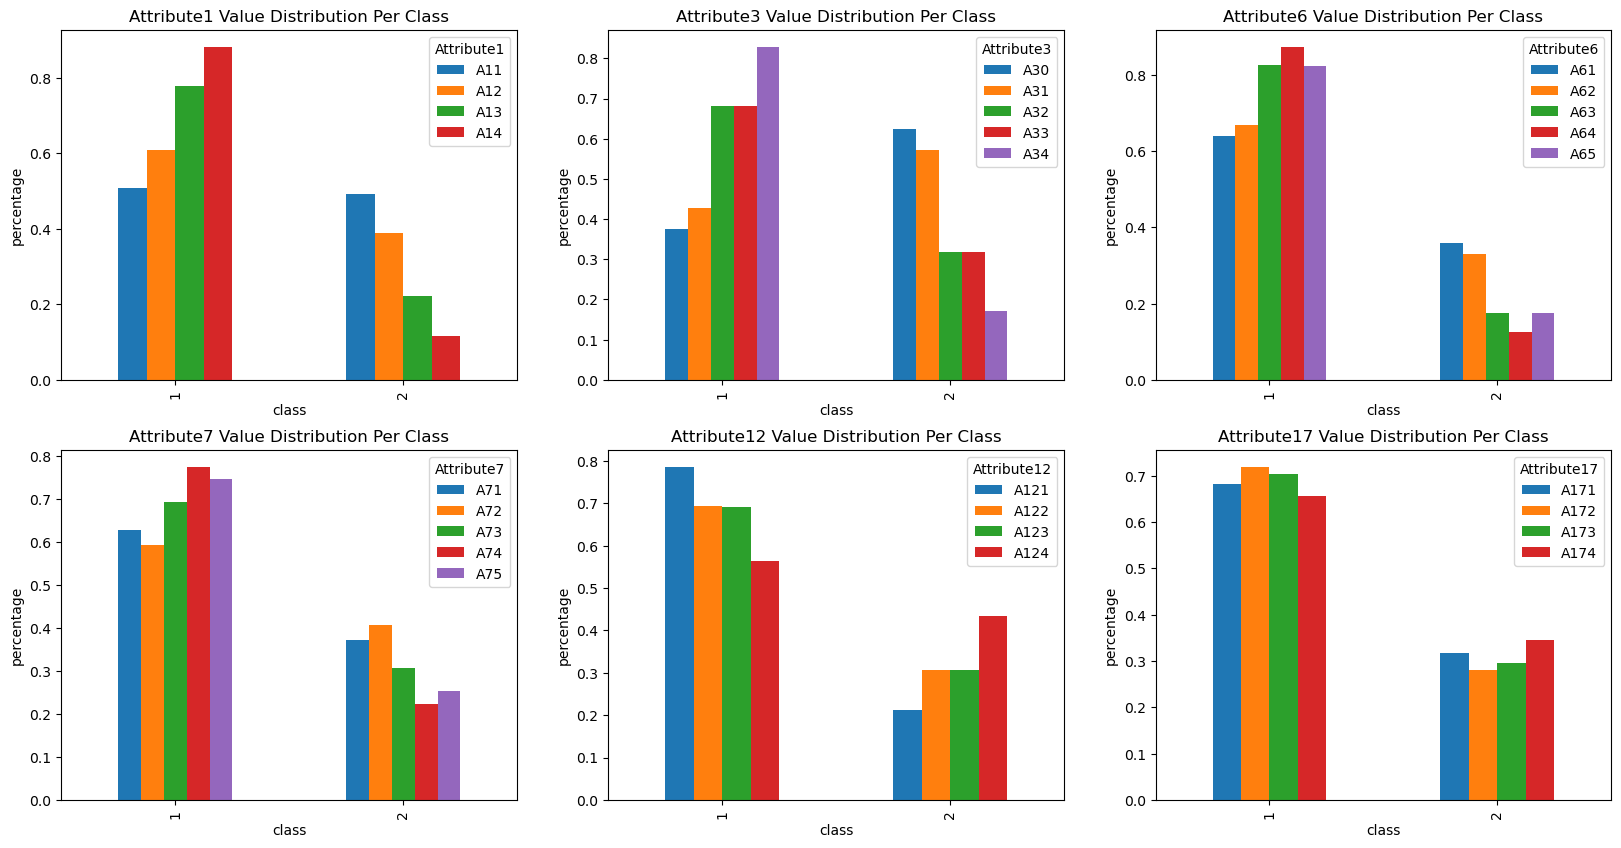

In [41]:
fig, axes = plt.subplots(2,3, figsize=(20,10))



for i, a in enumerate(['Attribute1', 'Attribute3', 'Attribute6', 'Attribute7', 'Attribute12', 'Attribute17']):
    
    row = i // 3
    col = i % 3
    
    ax = axes[row,col]
    
    grouped = pd.concat([german_data_X[a],german_data_Y], axis=1).groupby(['class',a]).size()
    attr_counts = german_data_X[a].value_counts()
    creditworthy_values = grouped.reset_index(name='count')
    creditworthy_values['percent_in_class'] = creditworthy_values.apply(lambda x: x['count']/attr_counts[x[a]], axis=1)
    creditworthy_values.pivot(index='class', columns=a, values='percent_in_class').plot(kind='bar', title=f"{a} Value Distribution Per Class",
                                                                                        xlabel='class', ylabel="percentage", ax=ax, legend=True)

plt.show()

Changing order:

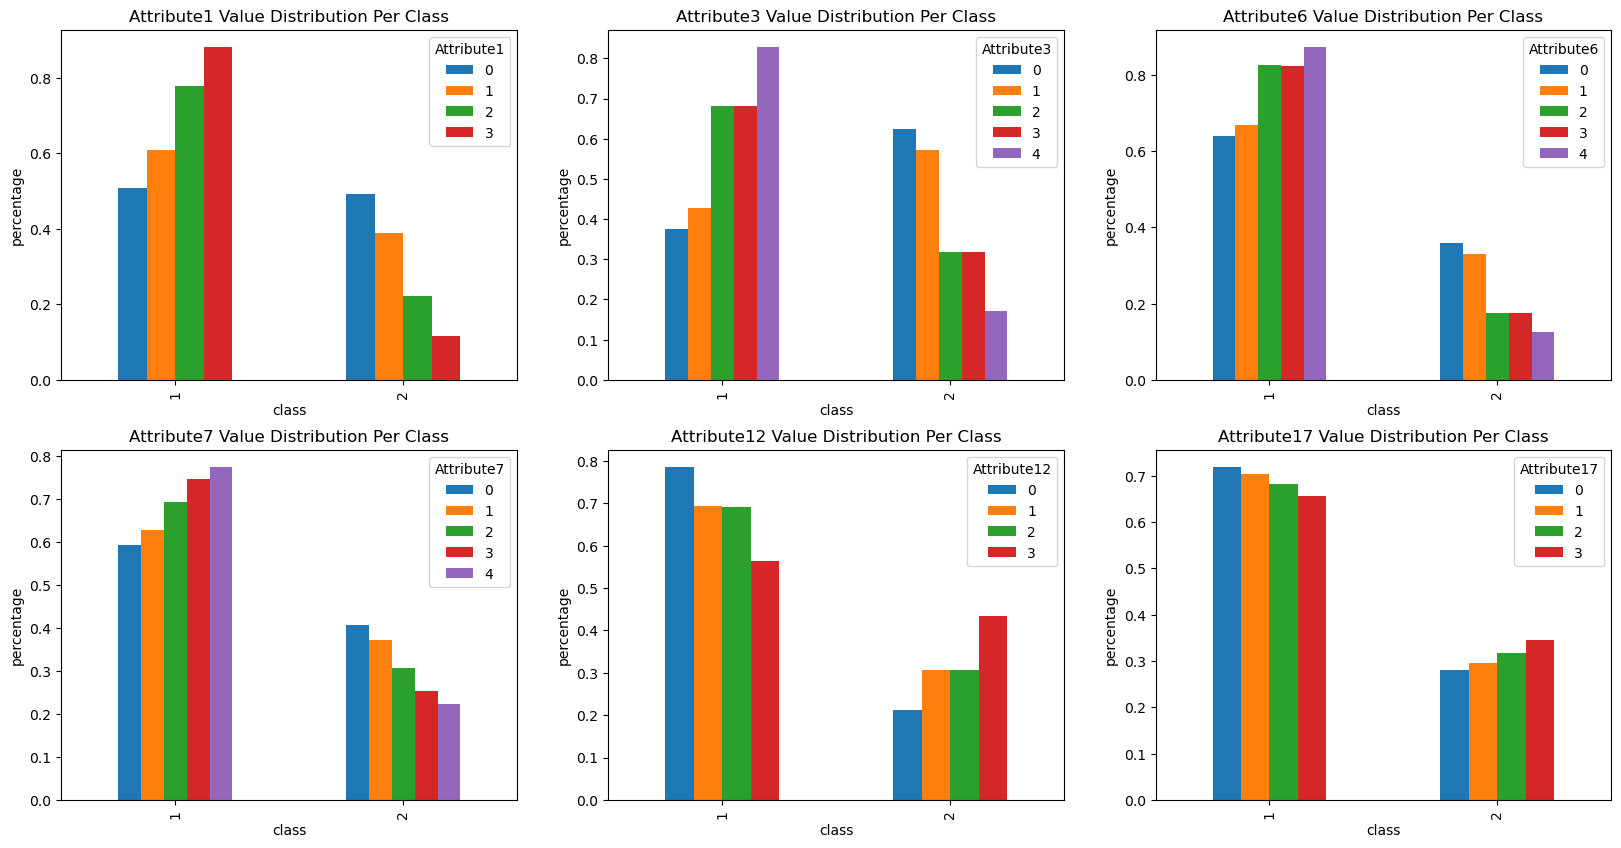

In [42]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
label_encoder = LabelEncoder()

for i, a in enumerate(['Attribute1', 'Attribute3', 'Attribute6', 'Attribute7', 'Attribute12', 'Attribute17']):
    
    row = i // 3
    col = i % 3
    ax = axes[row,col]
    
    if (a == 'Attribute6'):
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A65','temp')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A64','A65')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('temp','A64')
        
    elif (a == 'Attribute7'):
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A74','temp')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A75','A74')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('temp','A75')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A71','temp')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A72','A71')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('temp','A72')
    
    elif (a == 'Attribute17'):
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A174','A175')
        german_data_X_k_NN[a] = german_data_X_k_NN[a].replace('A171','A174')
        
    german_data_X_k_NN[a] = label_encoder.fit_transform(german_data_X_k_NN[a])
    
    grouped = pd.concat([german_data_X_k_NN[a],german_data_Y], axis=1).groupby(['class',a]).size()
    attr_counts = german_data_X_k_NN[a].value_counts()
    creditworthy_values = grouped.reset_index(name='count')
    creditworthy_values['percent_in_class'] = creditworthy_values.apply(lambda x: x['count']/attr_counts[x[a]], axis=1)
    
    creditworthy_values.pivot(index='class', columns=a, values='percent_in_class').plot(kind='bar',
                                                                                        title=f"{a} Value Distribution Per Class",
                                                                                        xlabel='class', ylabel="percentage", ax=ax, legend=True)
    

plt.show()

In [43]:
# ordinal attributes label encoded
german_data_X_k_NN[['Attribute1', 'Attribute3', 'Attribute6', 'Attribute7', 'Attribute12', 'Attribute17']].head()


,Attribute1,Attribute3,Attribute6,Attribute7,Attribute12,Attribute17
0,0,4,3,3,0,1
1,1,2,0,2,0,1
2,3,4,0,4,0,0
3,0,2,0,4,1,1
4,0,3,0,2,3,1


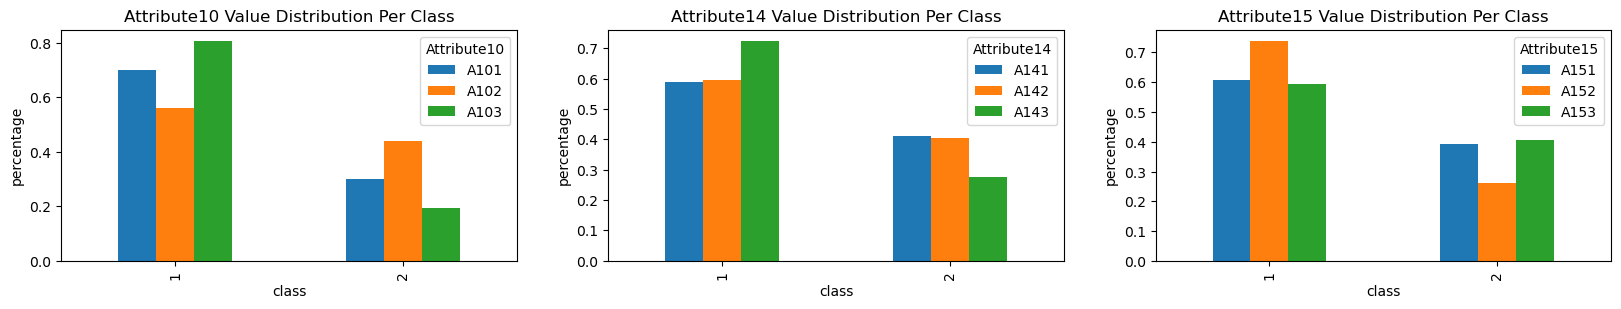

In [44]:
fig, axes = plt.subplots(1,3,figsize=(20,3))

for i, a in enumerate(['Attribute10', 'Attribute14', 'Attribute15']):
    
    ax = axes[i]
    
    grouped = pd.concat([german_data_X_k_NN[a],german_data_Y], axis=1).groupby(['class', a]).size().reset_index(name='count')
    attr_counts = german_data_X_k_NN[a].value_counts()
    grouped['percent_in_class'] = grouped.apply(lambda x: x['count']/attr_counts[x[a]], axis=1)
    grouped.pivot(index='class', columns=a, values='percent_in_class').plot(kind='bar',
                                                                             title=f"{a} Value Distribution Per Class",
                                                                             xlabel='class', ylabel="percentage", ax=ax, legend=True)
    

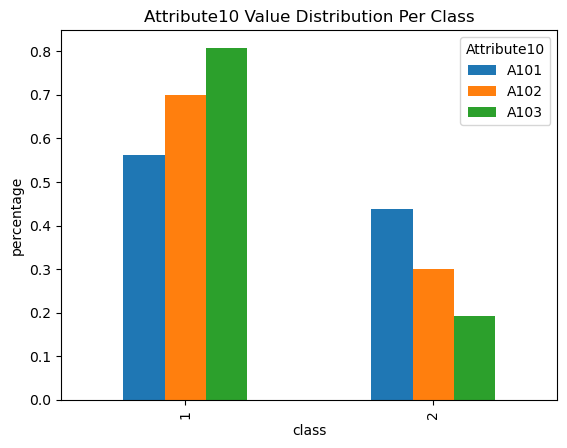

In [45]:
german_data_X_k_NN['Attribute10'] = german_data_X_k_NN['Attribute10'].replace('A101','temp')
german_data_X_k_NN['Attribute10'] = german_data_X_k_NN['Attribute10'].replace('A102','A101')
german_data_X_k_NN['Attribute10'] = german_data_X_k_NN['Attribute10'].replace('temp', 'A102')

grouped = pd.concat([german_data_X_k_NN['Attribute10'],german_data_Y], axis=1).groupby(['class', 'Attribute10']).size().reset_index(name='count')
attr_counts = german_data_X_k_NN['Attribute10'].value_counts()
grouped['percent_in_class'] = grouped.apply(lambda x: x['count']/attr_counts[x['Attribute10']], axis=1)
grouped.pivot(index='class', columns='Attribute10', values='percent_in_class').plot(kind='bar',
                                                                        title=f"{'Attribute10'} Value Distribution Per Class",
                                                                        xlabel='class', ylabel="percentage", legend=True)
plt.show()
    

In [46]:
# applying label encoding and one-hot encoding
german_data_X_k_NN['Attribute10'] = label_encoder.fit_transform(german_data_X_k_NN['Attribute10'])
german_data_X_k_NN = pd.get_dummies(data=german_data_X_k_NN,
                                         columns=['Attribute14', 'Attribute15']
                                         ).apply(
                                             lambda x: x.apply(lambda x: int(x) if isinstance(x,bool) else x)
                                             )
german_data_X_k_NN.loc[:,['Attribute10'] + list(german_data_X_k_NN.loc[:,'Attribute14_A141':].columns)].head()

,Attribute10,Attribute14_A141,Attribute14_A142,Attribute14_A143,Attribute15_A151,Attribute15_A152,Attribute15_A153
0,1,0,0,1,0,1,0
1,1,0,0,1,0,1,0
2,1,0,0,1,0,1,0
3,2,0,0,1,0,0,1
4,1,0,0,1,0,0,1


In [47]:
standard_scaler = StandardScaler()
numerical_attributes = ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
german_data_X_k_NN[numerical_attributes] = standard_scaler.fit_transform(X=german_data_X_k_NN[numerical_attributes])
german_data_X_k_NN[numerical_attributes].head()

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869


### German Credit Data (Decision Tree)

In [48]:
qualitative = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10',
               'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20',]
label_encoder = LabelEncoder()
german_data_X_tree = german_data_X.copy()
for q in qualitative:
    german_data_X_tree[q] = label_encoder.fit_transform(german_data_X_tree[q])

german_data_X_tree[qualitative].head()

,Attribute1,Attribute3,Attribute4,Attribute6,Attribute7,Attribute9,Attribute10,Attribute12,Attribute14,Attribute15,Attribute17,Attribute19,Attribute20
0,0,4,4,4,4,2,0,0,2,1,2,1,0
1,1,2,4,0,2,1,0,0,2,1,2,0,0
2,3,4,7,0,3,2,0,0,2,1,1,0,0
3,0,2,3,0,3,2,2,1,2,2,2,0,0
4,0,3,0,0,2,2,0,3,2,2,2,0,0


# Part I (Inference Efficiency):

### 2. Build k-NN classifier for k = 5 (German Data)

- A. Holdout method (90% train - 10% split) over 5 trials


In [49]:
f_measures_k_NN = np.array([])
test_times_k_NN = np.array([])

g_X_train, g_X_test, g_Y_train, g_Y_test = train_test_split(german_data_X_k_NN, german_data_Y,
                                                            test_size=0.1, shuffle=True,
                                                            stratify=german_data_Y['class'].to_numpy())

for i in range(5):
    
    clf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    clf.fit(g_X_train,g_Y_train['class'].to_numpy())
    
    starttime = time.time()
    g_Y_pred = clf.predict(g_X_test)
    endtime = time.time()
    
    f_measures_k_NN = np.append(f_measures_k_NN, f1_score(g_Y_test, g_Y_pred))
    test_times_k_NN = np.append(test_times_k_NN, endtime-starttime)

- B. Reporting final average F-measure and average test time

In [50]:
print(f"Final average F-measure for k-NN (German Data): {f_measures_k_NN.mean()}")
print(f"Final average test time for k-NN (German Data): {test_times_k_NN.mean()}")

Final average F-measure for k-NN (German Data): 0.8266666666666665
Final average test time for k-NN (German Data): 0.007392740249633789


### 3. Repeat (2) for Decision Tree Classifiers (Default Parameters) (German Data)

- A. Holdout method (90% train - 10% split) over 5 trials

In [51]:
f_measures_DT = np.array([])
test_times_DT = np.array([])

g_X_train, g_X_test, g_Y_train, g_Y_test = train_test_split(german_data_X_tree, german_data_Y,
                                                            test_size=0.1, shuffle=True,
                                                            stratify=german_data_Y['class'].to_numpy())

for i in range(5):
    
    clf = DecisionTreeClassifier()
    clf.fit(g_X_train,g_Y_train)
    
    starttime = time.time()
    g_Y_pred = clf.predict(g_X_test)
    endtime = time.time()
    
    f_measures_DT = np.append(f_measures_DT, f1_score(g_Y_test, g_Y_pred))
    test_times_DT = np.append(test_times_DT, endtime-starttime)

- B. Reporting final average F-measure and average test time

In [52]:
print(f"Final average F-measure for Decision Tree (German Data): {f_measures_DT.mean()}")
print(f"Final average test time for Decision Tree (German Data): {test_times_DT.mean()}")

Final average F-measure for Decision Tree (German Data): 0.799905731025065
Final average test time for Decision Tree (German Data): 0.001433992385864258


### 2. Build k-NN classifier for k = 5 (Waveform Data)

- A. Holdout method (90% train - 10% split) over 5 trials


In [53]:
f_measures_k_NN_w = np.array([])
test_times_k_NN_w = np.array([])

w_X_train, w_X_test, w_Y_train, w_Y_test = train_test_split(waveform_data_X, waveform_data_Y,
                                                            test_size=0.1, shuffle=True)

for i in range(5):
    
    clf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    clf.fit(w_X_train,w_Y_train['class'].to_numpy())
    
    starttime = time.time()
    w_Y_pred = clf.predict(w_X_test)
    endtime = time.time()
    
    # since each class has a roughly equal number of instances, the 'macro' average argument is appropriate
    f_measures_k_NN_w = np.append(f_measures_k_NN_w, f1_score(w_Y_test, w_Y_pred, average='macro'))

    test_times_k_NN_w = np.append(test_times_k_NN_w, endtime-starttime)

- B. Reporting final average F-measure and average test time

In [54]:
print(f"Final average F-measure for k-NN (Waveform Data): {f_measures_k_NN_w.mean()}")
print(f"Final average test time for k-NN (Waveform Data): {test_times_k_NN_w.mean()}")

Final average F-measure for k-NN (Waveform Data): 0.8049833953291893
Final average test time for k-NN (Waveform Data): 0.03356423377990723


### 3. Repeat (2) for Decision Tree Classifiers (Default Parameters) (Waveform Data)

- A. Holdout method (90% train - 10% split) over 5 trials

In [55]:
f_measures_DT_w = np.array([])
test_times_DT_w = np.array([])


for i in range(5):
    
    clf = DecisionTreeClassifier()
    clf.fit(w_X_train,w_Y_train)
    
    starttime = time.time()
    w_Y_pred = clf.predict(w_X_test)
    endtime = time.time()
    
    f_measures_DT_w = np.append(f_measures_DT_w, f1_score(w_Y_test, w_Y_pred, average='macro'))
    test_times_DT_w = np.append(test_times_DT_w, endtime-starttime)

- B. Reporting final average F-measure and average test time

In [56]:
print(f"Final average F-measure for Decision Tree (Waveform Data): {f_measures_DT_w.mean()}")
print(f"Final average test time for Decision Tree (Waveform Data): {test_times_DT_w.mean()}")

Final average F-measure for Decision Tree (Waveform Data): 0.7369372803810847
Final average test time for Decision Tree (Waveform Data): 0.0009397029876708985


### 4. Compare results of (2) and (3) (German Data)

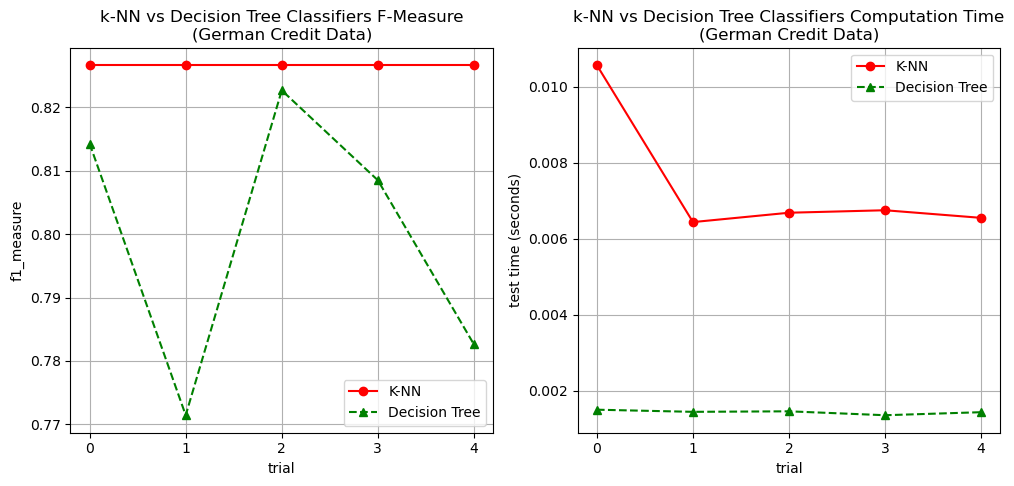

In [57]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

ax1 = axes[0]
ax2 = axes[1]

ax1.plot(np.arange(5), f_measures_k_NN, 'ro-', label='K-NN')
ax1.plot(np.arange(5), f_measures_DT, 'g^--', label="Decision Tree")
ax1.legend()
ax1.set_ylabel('f1_measure')
ax1.set_xlabel('trial')
ax1.set_title('k-NN vs Decision Tree Classifiers F-Measure\n(German Credit Data)')
ax1.set_xticks(np.arange(5), labels=['0','1','2','3','4'])
ax1.grid(True)

ax2.plot(np.arange(5), test_times_k_NN, 'ro-', label='K-NN')
ax2.plot(np.arange(5), test_times_DT, 'g^--', label="Decision Tree")
ax2.legend()
ax2.set_ylabel('test time (seconds)')
ax2.set_xlabel('trial')
ax2.set_title('k-NN vs Decision Tree Classifiers Computation Time\n(German Credit Data)')
ax2.set_xticks(np.arange(5), labels=['0','1','2','3','4'])
ax2.grid(True)
plt.show()

### 4. Compare results of (2) and (3) (Waveform Data)

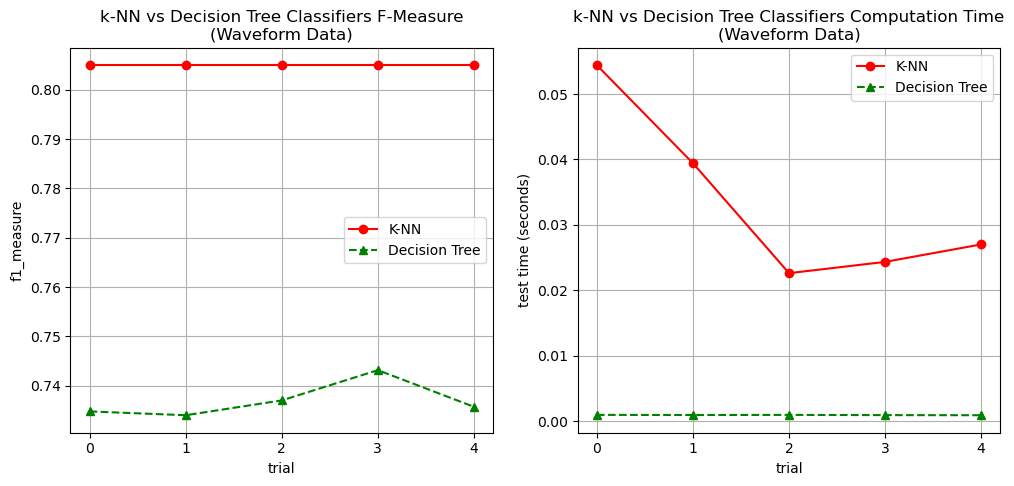

In [58]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

ax1 = axes[0]
ax2 = axes[1]

ax1.plot(np.arange(5), f_measures_k_NN_w, 'ro-', label='K-NN')
ax1.plot(np.arange(5), f_measures_DT_w, 'g^--', label="Decision Tree")
ax1.legend()
ax1.set_ylabel('f1_measure')
ax1.set_xlabel('trial')
ax1.set_title('k-NN vs Decision Tree Classifiers F-Measure\n(Waveform Data)')
ax1.set_xticks(np.arange(5), labels=['0','1','2','3','4'])
ax1.grid(True)

ax2.plot(np.arange(5), test_times_k_NN_w, 'ro-', label='K-NN')
ax2.plot(np.arange(5), test_times_DT_w, 'g^--', label="Decision Tree")
ax2.legend()
ax2.set_ylabel('test time (seconds)')
ax2.set_xlabel('trial')
ax2.set_title('k-NN vs Decision Tree Classifiers Computation Time\n(Waveform Data)')
ax2.set_xticks(np.arange(5), labels=['0','1','2','3','4'])
ax2.grid(True)
plt.show()

# Part II (Model Selection):

### Build K-NN for different k (1,2,3,4,5) and select best k:

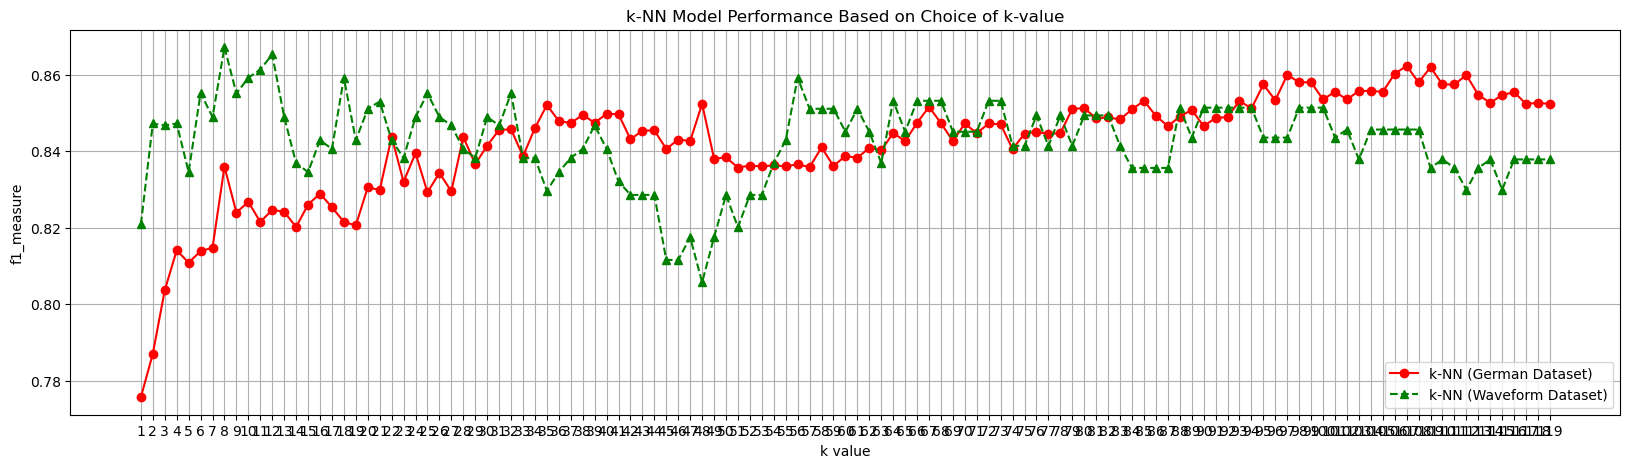

In [162]:
K = np.arange(1,120)
f_measures_k_NN_g = np.array([])
f_measures_k_NN_w = np.array([])

g_X_train, g_X_test, g_Y_train, g_Y_test = train_test_split(german_data_X_k_NN, german_data_Y,
                                                            test_size=0.1, shuffle=True,
                                                            stratify=german_data_Y['class'].to_numpy())
g_X_train, g_X_valid, g_Y_train, g_Y_valid = train_test_split(g_X_train, g_Y_train,
                                                              test_size=0.1, shuffle=True,
                                                              stratify=g_Y_train['class'].to_numpy())
w_X_train, w_X_test, w_Y_train, w_Y_test = train_test_split(waveform_data_X, waveform_data_Y,
                                                            test_size=0.1, shuffle=True,
                                                            stratify=waveform_data_Y['class'].to_numpy())
w_X_train, w_X_valid, w_Y_train, w_Y_valid = train_test_split(w_X_train, w_Y_train,
                                                              test_size=0.1, shuffle=True,
                                                              stratify=w_Y_train['class'].to_numpy())

for k in K:

    clf_g = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf_g.fit(g_X_train, g_Y_train['class'].to_numpy())
    g_Y_validPred = clf_g.predict(g_X_valid)
    f_measures_k_NN_g = np.append(f_measures_k_NN_g, f1_score(g_Y_validPred, g_Y_valid))

    clf_w = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf_w.fit(w_X_train, w_Y_train['class'].to_numpy())
    w_Y_validPred = clf_w.predict(w_X_valid)
    f_measures_k_NN_w = np.append(f_measures_k_NN_w, f1_score(w_Y_validPred, w_Y_valid, average='macro'))

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(K, f_measures_k_NN_w, 'ro-', label='k-NN (German Dataset)')
ax.plot(K, f_measures_k_NN_g, 'g^--', label="k-NN (Waveform Dataset)")
ax.legend()
ax.set_xticks(K, labels=[str(x) for x in K])
ax.set_ylabel('f1_measure')
ax.set_xlabel('k value')
ax.set_title('k-NN Model Performance Based on Choice of k-value')
ax.grid(True)

### Build Decision Tree for different depths (3, 4, ..., 10) and select best depth:

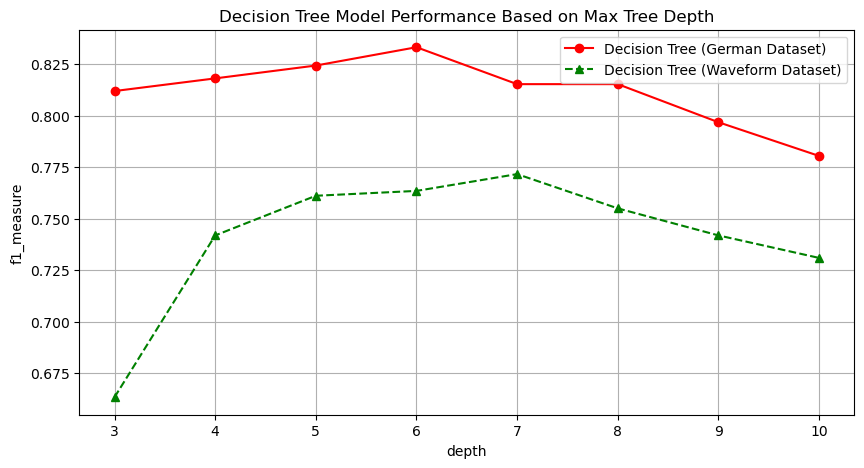

In [159]:
depths = np.arange(3,11)
f_measures_DT_g = np.array([])
f_measures_DT_w = np.array([])

g_X_train, g_X_test, g_Y_train, g_Y_test = train_test_split(german_data_X_tree, german_data_Y,
                                                            test_size=0.1, shuffle=True,
                                                            stratify=german_data_Y['class'].to_numpy())
g_X_train, g_X_valid, g_Y_train, g_Y_valid = train_test_split(g_X_train, g_Y_train,
                                                              test_size=0.1, shuffle=True,
                                                              stratify=g_Y_train['class'].to_numpy())
w_X_train, w_X_test, w_Y_train, w_Y_test = train_test_split(waveform_data_X, waveform_data_Y,
                                                            test_size=0.1, shuffle=True,
                                                            stratify=waveform_data_Y['class'].to_numpy())
w_X_train, w_X_valid, w_Y_train, w_Y_valid = train_test_split(w_X_train, w_Y_train,
                                                              test_size=0.1, shuffle=True,
                                                              stratify=w_Y_train['class'].to_numpy())

for d in depths:

    clf_g = DecisionTreeClassifier(max_depth=d)
    clf_g.fit(g_X_train, g_Y_train['class'].to_numpy())
    g_Y_validPred = clf_g.predict(g_X_valid)
    f_measures_DT_g = np.append(f_measures_DT_g, f1_score(g_Y_validPred, g_Y_valid))

    clf_w = DecisionTreeClassifier(max_depth=d)
    clf_w.fit(w_X_train, w_Y_train['class'].to_numpy())
    w_Y_validPred = clf_w.predict(w_X_valid)
    f_measures_DT_w = np.append(f_measures_DT_w, f1_score(w_Y_validPred, w_Y_valid, average='macro'))

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(depths, f_measures_DT_g, 'ro-', label='Decision Tree (German Dataset)')
ax.plot(depths, f_measures_DT_w, 'g^--', label="Decision Tree (Waveform Dataset)")
ax.legend()
ax.set_xticks(depths, labels=[str(x) for x in depths])
ax.set_ylabel('f1_measure')
ax.set_xlabel('depth')
ax.set_title('Decision Tree Model Performance Based on Max Tree Depth')
ax.grid(True)
plt.show()